In [1321]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [1322]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [1323]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True,min_df=0.05)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [1324]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [1325]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [1326]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size=.75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [1327]:
active_train_df = pd.DataFrame(active_train)
active_test_df = pd.DataFrame(active_test)
active_binding_train_df = pd.DataFrame(active_binding_train)
active_binding_test_df = pd.DataFrame(active_binding_test)

active_train_df['binding'] = active_binding_train_df['binding']
active_test_df['binding'] = active_binding_test_df['binding']

In [1328]:
not_active_train_df = pd.DataFrame(not_active_train)
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_train_df = pd.DataFrame(not_active_binding_train)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)

not_active_train_df['binding'] = not_active_binding_train_df['binding']
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [1329]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    505
1     58
Name: binding, dtype: int64
0    217
1     20
Name: binding, dtype: int64


In [1330]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)
x_test_sampled, y_test_sampled = sampler.fit_resample(np.array(test_df.sequence).reshape(-1,1),test_df.binding)

In [1331]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(x_test_sampled, columns  =["sequence"])
final_test_set['binding'] = y_test_sampled
print(final_test_set.binding.value_counts())

1    505
0    505
Name: binding, dtype: int64
1    217
0    217
Name: binding, dtype: int64


In [1332]:
vectorizer_global, training_features = return_binary_vectorized_form(final_train_set.sequence)
k_best_feature = select_k_best_features(training_features, final_train_set.binding, 0.50, vectorizer_global.get_feature_names_out())
vectorizer_k_best, training_split = return_binary_vectorized_form_with_vocab(final_train_set.sequence,k_best_feature)
test_split = vectorizer_k_best.transform(final_test_set.sequence).toarray()

In [1333]:
print(training_split.shape)
print(test_split.shape)

(1010, 852)
(434, 852)


In [1334]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
print(train_result.shape)
print(test_result.shape)

(1010,)
(434,)


In [1335]:
test_result.sum()

217

In [1336]:
train_result.sum()

505

In [1390]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
training_split = pca.fit_transform(training_split)
test_split = pca.transform(test_split)

In [1407]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    # tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(4,activation='relu', kernel_regularizer=tf.keras.regularizers.L1(.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [1408]:
from sklearn.metrics import f1_score
# def x(a,b):
#     tf.make_ndarray(a.op.get_attr('value'))
#     y = tf.make_ndarray(a.op.get_attr('value'))
#     return y.shape[-1]
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'),
      # x
     # precision-recall curve

]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=METRICS)

In [1409]:
num_epochs = 14
history = model.fit(training_split, train_result, epochs=num_epochs, validation_data=(test_split, test_result))
# ,callbacks=[tf.keras.callbacks.EarlyStopping()]

Epoch 1/14


/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-10-07 02:15:33.172744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 13.7655 - tp: 194.0000 - fp: 240.0000 - tn: 265.0000 - fn: 311.0000 - accuracy: 0.4545 - precision: 0.4470 - recall: 0.3842 - auc: 0.4603 - prc: 0.4888

2022-10-07 02:15:38.952874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 10s 231ms/step - loss: 13.7655 - tp: 194.0000 - fp: 240.0000 - tn: 265.0000 - fn: 311.0000 - accuracy: 0.4545 - precision: 0.4470 - recall: 0.3842 - auc: 0.4603 - prc: 0.4888 - val_loss: 10.6084 - val_tp: 83.0000 - val_fp: 80.0000 - val_tn: 137.0000 - val_fn: 134.0000 - val_accuracy: 0.5069 - val_precision: 0.5092 - val_recall: 0.3825 - val_auc: 0.5948 - val_prc: 0.5088
Epoch 2/14
32/32 [==============================] - 1s 36ms/step - loss: 8.2325 - tp: 232.0000 - fp: 183.0000 - tn: 322.0000 - fn: 273.0000 - accuracy: 0.5485 - precision: 0.5590 - recall: 0.4594 - auc: 0.5386 - prc: 0.5467 - val_loss: 5.9068 - val_tp: 106.0000 - val_fp: 43.0000 - val_tn: 174.0000 - val_fn: 111.0000 - val_accuracy: 0.6452 - val_precision: 0.7114 - val_recall: 0.4885 - val_auc: 0.7126 - val_prc: 0.6124
Epoch 3/14
32/32 [==============================] - 1s 26ms/step - loss: 4.2863 - tp: 261.0000 - fp: 81.0000 - tn: 424.0000 - fn: 244.0000 - accuracy: 0.6782 - prec

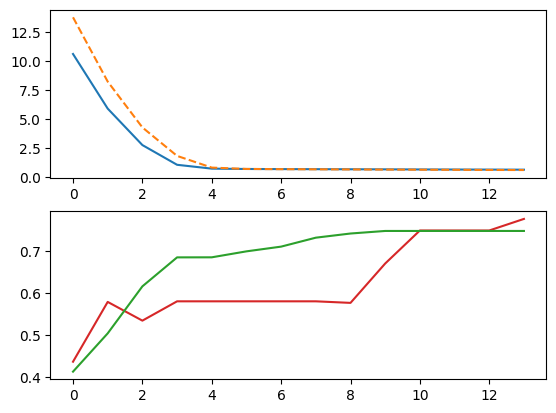

In [1410]:
fig, (ax1,ax2) = plt.subplots(2,1)
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)

ax1.plot(history.epoch, testloss, '-')
ax1.plot(history.epoch, trainloss, '--')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')

train_precision = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
train_recall= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
j =( 2 * train_precision * train_recall) / (train_precision+train_recall)

test_precission = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
test_recall = np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
k = (2 * test_precission * test_recall )/ (test_precission+test_recall)
# plt.plot(history.epoch,j, '-')
# plt.plot(k,'--')

ax2.plot(history.epoch, k, 'tab:red')
ax2.plot(history.epoch, j, 'tab:green')

# ax3.plot(j+3)
# ax3.plot(trainloss,'tab:blue')

In [1411]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [1417]:
unlabeled_test_sequence = vectorizer_k_best.transform(table_test.sequence).toarray()
unlabeled_test_sequence = pca.transform(unlabeled_test_sequence)

In [1418]:
unlabeled_test_sequence.shape

(350, 276)

In [1419]:
y = model.predict(unlabeled_test_sequence)

11/11 [==============================] - 0s 9ms/step


2022-10-07 02:17:01.978794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [1420]:
y

array([[0.5289991 ],
       [0.36453196],
       [0.3792348 ],
       [0.37128544],
       [0.371615  ],
       [0.37983915],
       [0.38721794],
       [0.40105462],
       [0.39411953],
       [0.45972976],
       [0.3736221 ],
       [0.37279025],
       [0.38613498],
       [0.3813309 ],
       [0.36975747],
       [0.37667176],
       [0.35949478],
       [0.40578744],
       [0.381315  ],
       [0.37109184],
       [0.3695077 ],
       [0.3844612 ],
       [0.359096  ],
       [0.36263132],
       [0.41751176],
       [0.70541364],
       [0.37792617],
       [0.36935413],
       [0.37973034],
       [0.36908007],
       [0.36205193],
       [0.3731683 ],
       [0.3659916 ],
       [0.3566588 ],
       [0.38608053],
       [0.368617  ],
       [0.36570716],
       [0.39196125],
       [0.36366916],
       [0.3771326 ],
       [0.36641672],
       [0.37624562],
       [0.36497924],
       [0.37270543],
       [0.36170304],
       [0.37407747],
       [0.37388054],
       [0.389

In [1421]:
# for i in range(3):
z = [1 if i>=.5 else 0 for i in y ]

In [1422]:
z[61]

1

In [945]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], z))
outfile.close()

In [ ]:
ls